### Exploratory analysis to better understand the peak flooding date.

---
1. Imports, loading, and preprocessing
---

In [259]:
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import operator

In [2]:
# Go to root repo directory
os.chdir('..')

In [3]:
# Remove default warning message on chained variable assignments
pd.options.mode.chained_assignment = None  

In [4]:
# Reading in the data
interview = pd.read_excel('data/processed/Sentinel-1-BGD-Flooding_INTERVIEW.xlsx', sheet_name='Sheet1_COPY', parse_dates=['date'])
updated = pd.read_excel('data/processed/Sentinel-1-BGD-Flooding-updated.xlsx', parse_dates=['date'])

In [5]:
# Drop unnecessary columns
dropped = updated.drop(updated.columns[[0,1,2,19]], axis=1)

# Merge flood extent with the interview data 
merged = dropped.merge(interview.iloc[:, np.r_[1,7, 15,19:31]], on=['ADM4_EN', 'ADM3_EN','date'], how='left')

---
2. Data processing functions
---

In [6]:
# Create dataframe in time series of flood extent, grouped by given admin level
def make_ts(df, group):
    copy = df 
    copy['date'] = pd.to_datetime(copy['date'], format = "%Y-%m-%d").dt.strftime('%Y-%m-%d')
    copy = copy.groupby(['date', group]).mean().reset_index()
    output = copy[[group, 'flood_fraction', 'date']]
    return output

# Create line plot of the time series flood extent data 
def graph_ts(ts):
    copy = ts
    copy['date']= pd.to_datetime(copy['date'])
    copy = copy.set_index(['date'])
    copy.groupby(copy.columns[0])['flood_fraction'].plot(legend=True)
    plt.xticks(rotation=45)
    plt.ylabel('Percent flooded')
    plt.xlabel('Date')
    return plt

# Return a dataframe with only peak flooding dates as rows, including both ADM1 and ADM2 names
def peak_ts(ts, df):
    copy = ts 
    admin = copy.columns[0]
    output = (copy
               .groupby([admin])['flood_fraction']
               .max()
               .reset_index()
               .merge(copy[['flood_fraction', 'date']], on='flood_fraction', how='left')
               .merge(df, on=admin)
               .drop_duplicates(subset=admin))
    output = output[['ADM3_EN','ADM4_EN', 'ADM2_EN', 'date_x', 'flood_fraction_x']].rename(columns=
                                                                                 {'ADM3_EN':'ADM3_EN',
                                                                                  'ADM4_EN': 'ADM4_EN',
                                                                                  'ADM2_EN': 'ADM2_EN',
                                                                                  'date_x': 'date', 
                                                                                  'flood_fraction_x':'flood_fraction'})
    return output

In [296]:
# Get the xs and the ys
# Inputs are the level of admin aggregation, 
# an index to access a region of interest, 
# and a dataframe to pass to the make_ts function
def getXY(admin, index, df):
    ts_data = make_ts(df, admin)
    # Create a column with time as numeric 
    ts_data['time_int'] = [time.mktime(time.strptime(date, '%Y-%m-%d')) for date in ts_data['date']]
    # Select an admin area of interest  
    unique = ts_data[admin].unique()[index]
    sel = ts_data.loc[ts_data[admin] == unique].reset_index()
    # Define the x and y
    y = np.array(sel['flood_fraction'])
    x = np.array(sel['time_int'])
    return x,y


# Fit input x and y data to Gaussian function
# Adapted from https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
# Returns the fitted y values 
def gaussFit(x_pred,x_actual,y_actual):
    mean = sum(x_actual * y_actual) / sum(y_actual)
    sigma = np.sqrt(sum(y_actual * (x_actual - mean) ** 2) / sum(y_actual))
    popt, pcov = curve_fit(gauss, x_actual, y_actual, p0=[min(y_actual), max(y_actual), mean, sigma])
    return popt[0] + popt[1] * np.exp(-(x_pred - popt[2]) ** 2 / (2 * popt[3] ** 2))
 
    
# Fit input x and y data to Polynomial function
# d = degree of the function
# Returns the fitted y values 
def polyFit(x_pred,x_actual,y_actual,d):
    # calculate polynomial
    z = np.polyfit(x_actual, y_actual, degree)
    func = np.poly1d(z)
    return func(x_pred)


# Get the RMSE from predicted and actual values
# Assumes they are the same length!
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())   


# Get the peak flooding date
# Inputs are the x (dates) and y (flood extent) data (pred or normal)
def getPeak(dates, extents):
    index, value = max(enumerate(extents), key=operator.itemgetter(1))
    return (datetime
            .datetime
            .fromtimestamp(dates[index])
            .strftime('%Y-%m-%d'))

---
3. Results
---

Original peak: 2020-07-27
Fitted peak Gaussian: 2020-07-24
Fitted peak Polynomial: 2020-07-23


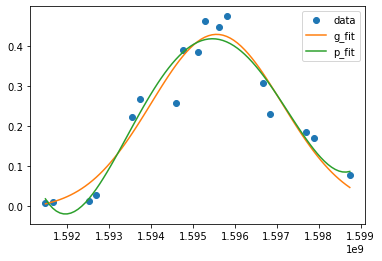

In [316]:
# 0. Set the params
ADM = 'ADM2_EN'
INDEX = 2

# 1. Get the x and y
x,y = getXY(ADM, INDEX, merged)[0], getXY(ADM, INDEX, merged)[1]

# 2. Fit function to generate new data at daily intervals
x_new = np.linspace(x[0], x[-1], 85)
y_new_g = gaussFit(x_new,x, y)
y_new_p = polyFit(x_new,x, y, 3)

# 3. Plot the actual and fitted data
plt.plot(x, y, 'o', label='data')
plt.plot(x_new, y_new_g, label='g_fit')
plt.plot(x_new, y_new_p, label='p_fit')
plt.legend()

# 4. Calculate the peak dates 
print('Original peak: ' + getPeak(x,y))
print('Fitted peak Gaussian: ' + getPeak(x_new,y_new_g))
print('Fitted peak Polynomial: ' + getPeak(x_new,y_new_p))

Figure below replicates past findings. We see the average flooding of all unions in the following districts of interest. As has been identified, we can see that flooding has peaked across all districts in late July. 

<module 'matplotlib.pyplot' from 'C:\\Users\\Hannah\\anaconda3\\envs\\bang_floods\\lib\\site-packages\\matplotlib\\pyplot.py'>

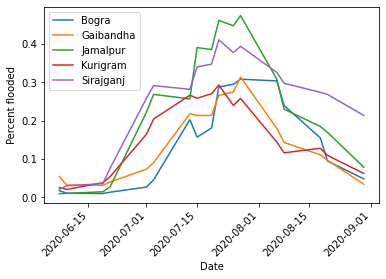

In [167]:
# Make a graph of the flooding fraction over time aggregated to the ADMIN 2 level
graph_ts(make_ts(merged, 'ADM2_EN'))

The scatterplot below shows the average flood fraction for all ADM3 regions during the peak flooding dates. Points are coloured by their corresponding ADM2 region (district). We can see that the peak flooding in most ADM3 regions of Kurigram and Sirajganj districts occurred first (21-07-2020). Peak flooding in ADM3 regions in Jamalpur and Gaibandha were most clustered around the next Sentinel measurement date (27-07-2020). 

(array([18456., 18460., 18464., 18468., 18472., 18475., 18479.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

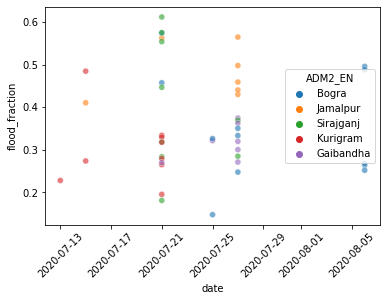

In [18]:
# Scatter plot to compare the peak flood date with max flood extent
# Calculated at the ADMIN 3 level but coloured by ADMIN 2
peak = peak_ts(make_ts(merged, 'ADM3_EN'), merged)
peak['date'] = pd.to_datetime(peak['date'])
sns.scatterplot(data=peak, x="date", y="flood_fraction", alpha=0.6, hue='ADM2_EN')
plt.xticks(rotation=45)